## Prepare Notebook

In [24]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import pandas as pd
import seaborn as sns
from jax import random
from numpyro.infer import MCMC, NUTS, Predictive
from sklearn.preprocessing import LabelEncoder

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

rng_key = random.PRNGKey(seed=0)

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read Data

In [2]:
cookies = pd.read_csv("../data/cookies.dat", sep=" ")

cookies.head()

,chips,location
0,12,1
1,12,1
2,6,1
3,13,1
4,12,1


## EDA

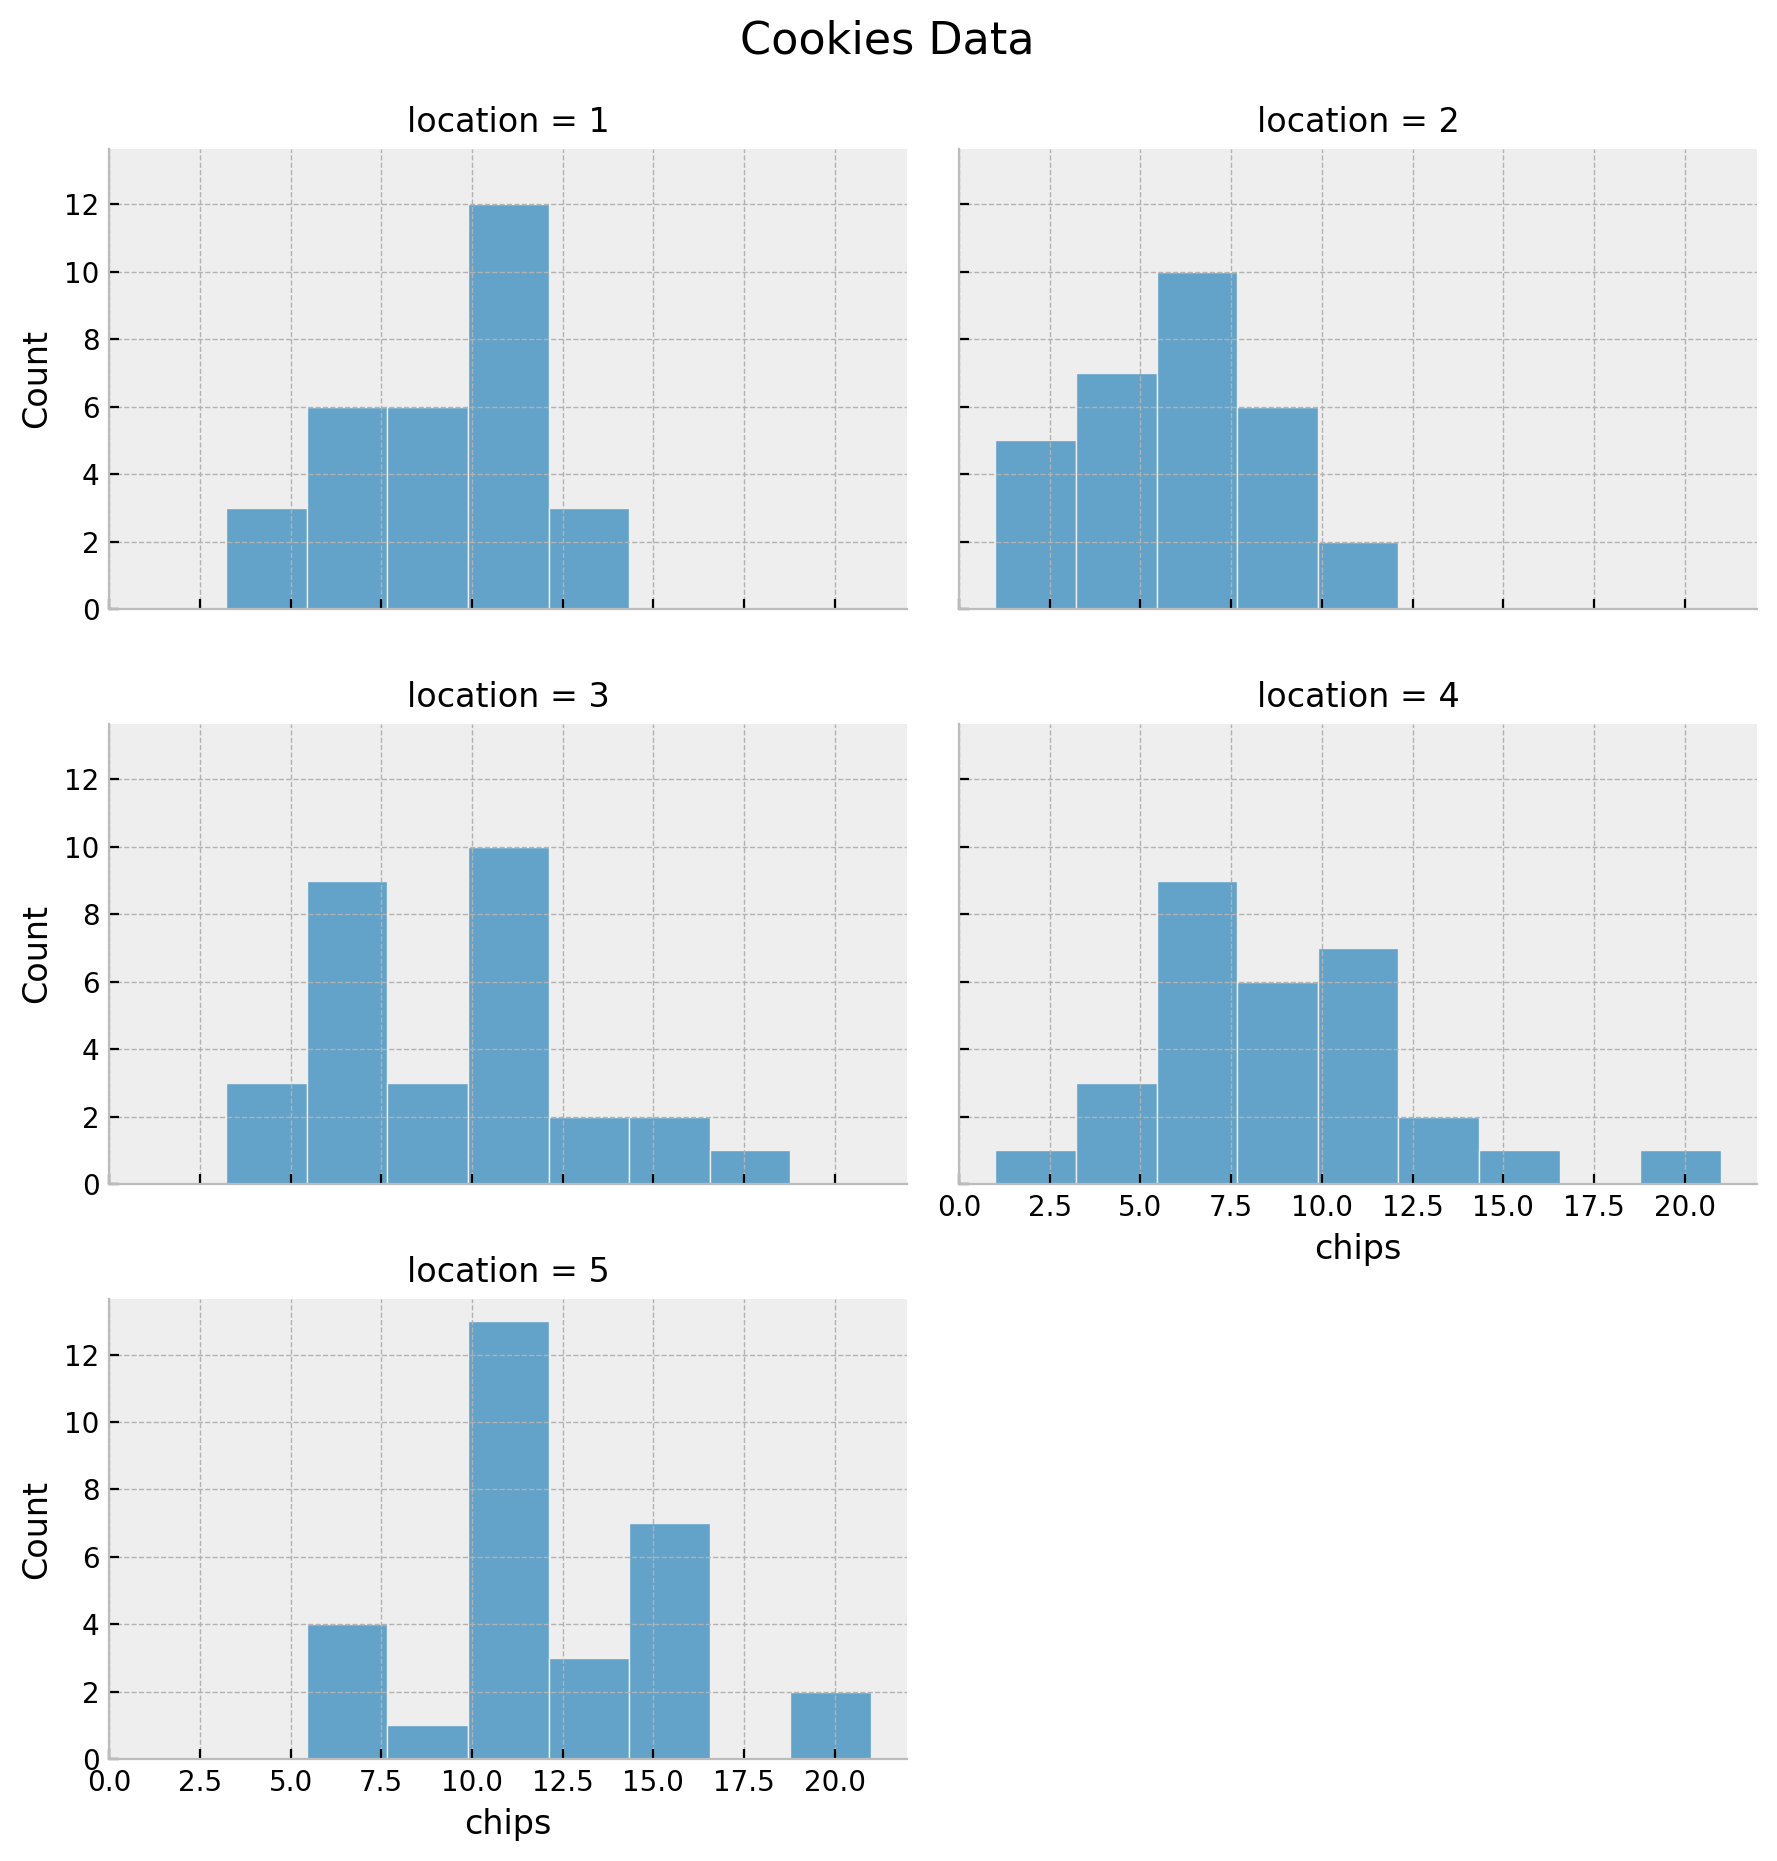

In [8]:
g = sns.displot(
    data=cookies,
    x="chips",
    kind="hist",
    col="location",
    col_wrap=2,
    height=3,
    aspect=1.5,
)
g.fig.suptitle("Cookies Data", y=1.03, fontsize=16)

In [12]:
cookies.groupby("location").agg(
    {"chips": ["count", "min", "max", "median", "mean", "var"]}
)


chips                                     
         count min max median       mean        var
location                                           
1           30   4  14    9.5   9.300000   8.010345
2           30   1  11    6.0   5.966667   6.447126
3           30   4  18   10.0   9.566667  13.012644
4           30   1  21    8.0   8.933333  15.029885
5           30   6  20   11.0  12.000000  13.724138

In [13]:
location_encoder = LabelEncoder()

locations = location_encoder.fit_transform(cookies["location"])
chips = cookies["chips"].to_numpy()

## Pooled Model

In [18]:
def pooled_model(chips):
    rate = numpyro.sample(name="rate", fn=dist.Exponential(rate=1 / 10))
    numpyro.sample(name="obs", fn=dist.Poisson(rate=rate), obs=chips)


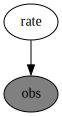

In [20]:
numpyro.render_model(pooled_model, model_args=(chips,))


In [23]:
pooled_nuts_kernel = NUTS(model=pooled_model, target_accept_prob=0.95)
pooled_mcmc = MCMC(
    sampler=pooled_nuts_kernel, num_samples=4_000, num_warmup=2_000, num_chains=4
)
rng_key, rng_subkey = random.split(key=rng_key)
pooled_mcmc.run(rng_subkey, chips)

pooled_posterior_samples = pooled_mcmc.get_samples()


/var/folders/xv/983bz0q51wbb27tjz2c4r40w0000gn/T/ipykernel_21915/264781024.py:2: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pooled_mcmc = MCMC(
sample: 100%|██████████| 6000/6000 [00:01<00:00, 3112.58it/s, 3 steps of size 8.37e-01. acc. prob=0.94]


## Unpooled Model

## Hierarchical Model

In [15]:
def hierarchical_model(locations, chips=None):
    mu = numpyro.sample(name="mu", fn=dist.Gamma(concentration=2, rate=1 / 5))
    sigma = numpyro.sample(name="sigma", fn=dist.Exponential(rate=1))
    alpha = numpyro.deterministic(name="alpha", value=mu**2 / sigma**2)
    beta = numpyro.deterministic(name="beta", value=mu / sigma**2)

    n_locations = np.unique(locations).size

    with numpyro.plate(name="plate", size=n_locations):
        lam = numpyro.sample(
            name="lam",
            fn=dist.Gamma(concentration=alpha, rate=beta),
        )

    n_obs = locations.size
    rate = lam[locations]

    with numpyro.plate(name="data", size=n_obs):
        numpyro.sample(name="obs", fn=dist.Poisson(rate=rate), obs=chips)

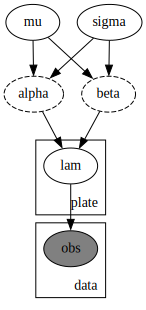

In [16]:
numpyro.render_model(hierarchical_model, model_args=(locations, chips))


In [ ]:
hierarchical_nuts_kernel = NUTS(model=hierarchical_model, target_accept_prob=0.95)
hierarchical_mcmc = MCMC(
    sampler=hierarchical_nuts_kernel, num_samples=4_000, num_warmup=2_000, num_chains=4
)
rng_key = random.PRNGKey(seed=0)
hierarchical_mcmc.run(rng_key, locations, chips)

hierarchical_posterior_samples = hierarchical_mcmc.get_samples()


In [ ]:
hierarchical_predictive = Predictive(
    model=hierarchical_model, posterior_samples=hierarchical_posterior_samples
)
rng_key, rng_subkey = random.split(rng_key)
posterior_predictive = predictive(rng_key_predictive, locations)

In [ ]:
hierarchical_idata = az.from_numpyro(
    posterior=hierarchical_mcmc, posterior_predictive=hierarchical_posterior_predictive
)

In [ ]:
axes = az.plot_trace(
    data=idata,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (10, 10), "layout": "constrained"},
)
plt.gcf().suptitle("Trace", fontsize=16)


In [ ]:
az.summary(data=hierarchical_idata)

In [ ]:
# az.plot_ppc(
#     data=idata,
#     kind="cumulative",
#     observed_rug=True,
#     backend_kwargs={"figsize": (12, 9)},
# )